In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import plot_confusion_matrix

# 1. Simulating Data

We're generating fake data that we're going to use to predict whether a customer at Target signs up for a rewards program (`rewards_signup`) based on 

* their age (`age`)
* their income (`income_in_k`), and 
* whether they made a purchase (`previous_purchase`) in the last month

Remember, each time you use a np.random.XXXX function, you'll get *different* fake data, because it's randomly generated. Try it out! If you want your data to come out the SAME each time, add the line `np.random.seed(XXXX)` at the top of the next cell, where `XXXX` is any integer you want like 42, 8675309, or 1234.

## 1.1 Logistic Regression Data Simulation

In [2]:
n = 100 # number of samples

In [3]:
# variables---
np.random.seed(42)

age = np.round(np.random.normal(37, 5, size = n),0)
income_in_k = np.round(np.random.normal(100,10, size = n), 2)
previous_purchase = np.random.binomial(1,0.5, size = n)

# set true coefficients---
a = 0.1 # age
i = 0.03 # income
p = 2.6 # previous purchase

inter = -8.2 # intercept

error = np.random.normal(0,0.25,size = n) # random error

# probability they signed up for reward program---
ex = np.exp(inter + a*age + i*income_in_k + p*previous_purchase + error) #predicted odds
reward_signup = (ex/(1 + ex)) #predicted probability


# you may also see the log reg formula like this---
# reward_signup = 1/(1 + (1/ex)) 


# yes/no did they sign up---
y = np.random.binomial(1, reward_signup) #generate random values


# make DataFrame---
df = pd.DataFrame({"age": age,
                  "income": income_in_k,
                  "previous_purchase": previous_purchase,
                  "signed_up": y})



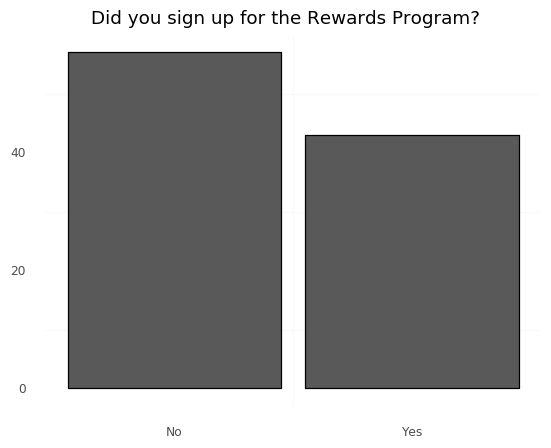

<ggplot: (8788125194448)>

In [4]:
# plot
(ggplot(df, aes(x = "y")) + geom_bar(color = "black") +
theme_minimal() + labs(title = "Did you sign up for the Rewards Program?", x = "", y = "") + 
theme(panel_grid_major = element_blank()) +
scale_x_continuous(breaks = [0,1], labels = ["No", "Yes"]))

## 1.2 Fit a Logistic Regression Model

In [5]:
features = ["age", "income", "previous_purchase"]
X = df[features]
y = df[["signed_up"]] #if you don't have the extra brackets, y will be a series instead of an array and throw an error


# create + fit a logistic regression
#########################################
lr = LogisticRegression()

lr.fit(X,y)
#########################################

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# grab the coefficients from the model and store them in a data frame----

#########################################
coef = pd.DataFrame({"Coef": lr.coef_[0], "Names": features})
coef = coef.append({"Coef": lr.intercept_[0], "Names": "intercept"}, ignore_index = True)
coef
#########################################

,Coef,Names
0,0.089866,age
1,0.072622,income
2,1.750402,previous_purchase
3,-11.846610,intercept


The coefficient of age is 0.089866, and the intercept is -11.846610. The coefficient of age indicates that as length increases by 1 year, we expect the log odds of signing up to increase by 0.0899 .

### *Question*

Compare that to the TRUE population values we set above (hint: print `a` and `inter`). How close are the numbers from *this* logistic regression to the true values? What do you think will happen if we created another random sample? 100 random samples?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

The coef for length that I got were close the true values, but not exactly. The true values are

`a = 0.1 # age`

`i = 0.03 # income`

`p = 2.6 # previous purchase`

`inter = -8.2 # intercept`

If we created a bunch more data sets, I would expect MOST coefs and intercepts to be close to the true values, but some (only a few) might be way off. The more different the estimate is from the true value, the less likely I expect it to be though.

### *Question*

What is the interpretation of the income coefficient?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

As income goes up by 1 unit (in k) the predicted *log odds* will increase by 0.03

# 2. Log Odds, Odds, and Probabilities

The coefficients for **log**istic regression are in terms of **log** odds. While this means that our regression formula is nice and easy to solve, log odds can be tough to wrap your head around. Often, we exponentiate the coefficients (using `np.exp()`) to get our coefficients in terms of odds rather than log odds.

## 2.1 Odds

We'll grab our coefficients from `coef` and exponentiate them:

In [7]:

#########################################
# add a new colum to your dataframe coef that has the coefficients in terms of ODDS
coef["Odds"] = np.exp(coef["Coef"])

coef
#########################################

,Coef,Names,Odds
0,0.089866,age,1.094028
1,0.072622,income,1.075324
2,1.750402,previous_purchase,5.756916
3,-11.846610,intercept,0.000007


The way you interpret coefficients in their exponentiated (odds) form is similar to how you interpret them in their raw form.

Here's an example of the difference:

**Raw Coefficient**: And increase in 1 year of age is associated with a 0.0899 increase in the log odds of signing up for the rewards program.

**Exponentiated Coefficient**: An increase in 1 year of age is associated with a 1.094x increase in the odds of signing up for the rewards program.

However, the math is slightly different.

### *Question*

What is the interpretation of the age and income coefficients in terms of *odds*?
<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

As income increases by 1k, the predicted odds will increase by 1.075x.

As age increases by 1 year, the predicted odds will increase by 1.094x.

## 2.2 More Odds

Using the coefficients generated by our model, let's look at how the predicted log odds and odds change when we play around with the values for `age`, `income`, and `previous_purchase`.

In [8]:
# Function to calculate the LOG ODDS based on coefs and predictor values

def calc_lo(age,income, previous_purchase, coefs):
    return(np.sum(np.array([age,income, previous_purchase, 1]) * coefs))

In [9]:
#########################################
age_value = 40
#########################################

# predicted logOdds for a 40 year old, with 121k income, no previous purchase
lo = calc_lo(age_value,121,0, coef["Coef"])
print("Log Odds for Original: " + str(lo))


# predicted logOdds for a 41 year old, with 121k income, no previous purchase
lo2 = calc_lo(age_value + 1,121,0, coef["Coef"])
print("Log Odds for +1 year : " + str(lo2))

# change in log odds for 1 year increase in age
print("\nThe difference in log odds is: "  + str(lo2-lo))

Log Odds for Original: 0.5353084347862271
Log Odds for +1 year : 0.6251742913210787

The difference in log odds is: 0.08986585653485157


### *Question*

The change in log odds for adding 1 year to a customer's age is equal to the coefficient for `age` from our model (As expected). Play around with the above code using different ages. How does the difference in predicted log odds change in response to a 1 year increase in age? Does it always change by the same amount?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>


Now let's look at the odds.

It's always constant no matter what values you use.


In [10]:
# Function to calculate the ODDS based on coefs and predictor values
# odds = e^lo

def calc_o(age,income, previous_purchase, coefs):
    return(np.exp(np.sum(np.array([age,income, previous_purchase, 1]) * coefs)))

In [11]:
#########################################
age_value = 40
#########################################

# predicted odds for a 40 year old, with 121k income, no previous purchase
o = calc_o(age_value,121,0, coef["Coef"])
print("Odds for Original: " + str(o))


# predicted odds for a 41 year old, with 121k income, no previous purchase
o2 = calc_o(age_value + 1,121,0, coef["Coef"])
print("Odds for +1 year : " + str(o2))

# change in odds for 1 year increase
print("\nThe ratio of odds is: "  + str(o2/o))

Odds for Original: 1.7079749599126537
Odds for +1 year : 1.8685716048661796

The ratio of odds is: 1.0940275172194205


Now try with a 27 year old.

In [12]:
age_value = 27

# predicted odds for a 27 year old, with 121k income, no previous purchase
o = calc_o(age_value,121,0, coef["Coef"])
print("Odds for Original: " + str(o))


# predicted odds for a 28 year old, with 121k income, no previous purchase
o2 = calc_o(age_value + 1,121,0, coef["Coef"])
print("Odds for +1 year : " + str(o2))

# change in odds for 1 year increase
print("\nThe ratio of odds is: "  + str(o2/o))

Odds for Original: 0.5310241916225003
Odds for +1 year : 0.5809550779442136

The ratio of odds is: 1.0940275172194203


### *Question*

The change in the ratio of odds for adding 1 year to a customer's age is equal to the exponentiated coefficient for `age` from our model (As expected). Now try plugging in some other ages. Is the change in the ratio (`o2/o`) *always* about 1.094 (there may be a small amount of rounding error)?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

It's always the same, and is always equal to the odds coef.

In [14]:
#########################################
# play around with different ages
age_value = 30
#########################################

# predicted odds for a 30 year old, with 121k income, no previous purchase
o = calc_o(age_value,121,0, coef["Coef"])
print("Odds for Original: " + str(o))


# predicted odds for a 31 year old, with 121k income, no previous purchase
o2 = calc_o(age_value + 1,121,0, coef["Coef"])
print("Odds for +1 year : " + str(o2))

# change in odds for 1 year increase
print("\nThe change in odds is: "  + str(o2/o))

Odds for Original: 0.6953429300614954
Odds for +1 year : 0.7607242993912549

The change in odds is: 1.0940275172194203


## 2.3 Probabilities are Problematic

If you work with people who aren't familiar with them, even odds can seem tricky to interpret. So people will often ask you to transform odds into probabilities.

In [15]:
# Function to calculate the probability based on coefs and predictor values

def calc_p(age,income, previous_purchase, coefs):
    odds = np.exp(np.sum(np.array([age,income, previous_purchase, 1]) * coefs))
    return(odds/(1+odds))

In [16]:
#########################################
age_value = 40
#########################################

# predicted prob for a 40 year old, with 121k income, no previous purchase
o = calc_p(age_value,121,0, coef["Coef"])
print("Probability for Original: " + str(o))


# predicted prob for a 41 year old, with 121k income, no previous purchase
o2 = calc_p(age_value + 1,121,0, coef["Coef"])
print("Probability for +1 year : " + str(o2))

# change in prob for 1 year increase
print("\nThe difference in probability is: "  + str(o2-o))
print("The change in probability is: "  + str(o2/o))

Probability for Original: 0.6307203667672558
Probability for +1 year : 0.6513944437351249

The difference in probability is: 0.02067407696786905
The change in probability is: 1.032778514944481


### *Question*

Play around with different ages. Is either the *difference* or the *ratio* of the probabilities constant no matter what age you start with?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

No, they change depending on the values that you use. They are not constant.

In [29]:
def calc_p(age,income, previous_purchase, coefs):
    odds = np.exp(np.sum(np.array([age,income, previous_purchase, 1]) * coefs))
    return(odds/(1+odds))

#########################################
# play around with age values
age_value = 0 
#########################################

# predicted prob for a ??? year old, with 121k income, no previous purchase
o = calc_p(age_value,121,0, coef["Coef"])
print("Probability for Original: " + str(o))


# predicted prob for a ??? +1 year old, with 121k income, no previous purchase
o2 = calc_p(age_value + 1,121,0, coef["Coef"])
print("Probability for +1 year : " + str(o2))

# change in prob for 1 year increase
print("\nThe difference in probability is: "  + str(o2-o))
print("The change in probability is: "  + str(o2/o))

Probability for Original: 0.04481655423032447
Probability for +1 year : 0.04882479638419229

The difference in probability is: 0.004008242153867823
The change in probability is: 1.0894366428366709


(Moral of the story probabilities can make more intuitive sense, but the amount a 1 unit increase in a predictor changes the predicted probability is *NOT CONSTANT*, it depends heavily on the values of the predictor of interest and all other predictors. If you're going to report in terms of probabilities you MUST be specific about what values all your predictors have.)

# 3. Accuracy Across Simulations

Now, let's use this function to generate *many* fake datasets that all have the same true coefficients. Similar to adding mse in the Linear Regression example, change the below function to also record the accuracy for each model and return it.

In [20]:
def logisticRegression(n = 100, age = 0.1, i = 0.03, p = 2.6, inter = -8.2):

    age = np.round(np.random.normal(37, 5, size = n),0)
    income_in_k = np.round(np.random.normal(100,10, size = n), 2)
    previous_purchase = np.random.binomial(1,0.5, size = n)
    
    error = np.random.normal(0,0.25,size = n) # random error

    # probability they signed up for reward program---
    ex = np.exp(inter + a*age + i*income_in_k + p*previous_purchase + error)
    reward_signup = (ex/(1 + ex)) 


    # you may also see the log reg formula like this---
    # reward_signup = 1/(1 + (1/ex)) 


    # yes/no did they sign up---
    y = np.random.binomial(1, reward_signup)
    
    # make DataFrame---
    df = pd.DataFrame({"age": age,
                      "income": income_in_k,
                      "previous_purchase": previous_purchase,
                      "signed_up": y})
    
    features = ["age", "income", "previous_purchase"]
    X = df[features]
    y = df[["signed_up"]] #if you don't have the extra brackets, y will be a series instead of an array and throw an error

    #########################################
    # run + fit a logistic regression
    lr = LogisticRegression()
    
    lr.fit(X,y)

    
    #########################################
    
    ##### ADD Acc CODE HERE ######
    acc = accuracy_score(y, lr.predict(X))
    ###############################
    
    
    # grab the coefficients from the model and store them in a data frame
    coef = pd.DataFrame({"Coef": lr.coef_[0], "Names": features})
    coef = coef.append({"Coef": lr.intercept_[0], "Names": "intercept"}, ignore_index = True)
    
    return({"coef": coef, "data": df, "acc": acc})

### *Question*

Simulate 500 datasets and plot a histogram of the accuracies. Remember, all these datasets are generated the exact same way and all have the exact same true values and error. What does the shape and spread of the histogram tell you about the accuracy values you observe when running a single model on a single (non-simulated) dataset?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>

In [24]:
n = 100
#run regression simulation 500 times
iWouldRun500Regressions = [logisticRegression() for x in range(0,500)]

# grab coefficients from 500 simulations
coef_df = pd.concat([x["coef"] for x in iWouldRun500Regressions])

# grab coefficients from 500 simulations
data_df = pd.concat([x["data"] for x in iWouldRun500Regressions])

# grab acc from 500 simulations
acc_df = pd.DataFrame({"acc": [x["acc"] for x in iWouldRun500Regressions]})

# number simulations 0:499
data_df["simulation_no"] = sorted(list(range(0,500))* n)
coef_df["simulation_no"] = sorted(list(range(0,500))*(len(features) + 1))
acc_df["simulation_no"] = list(range(0,500))

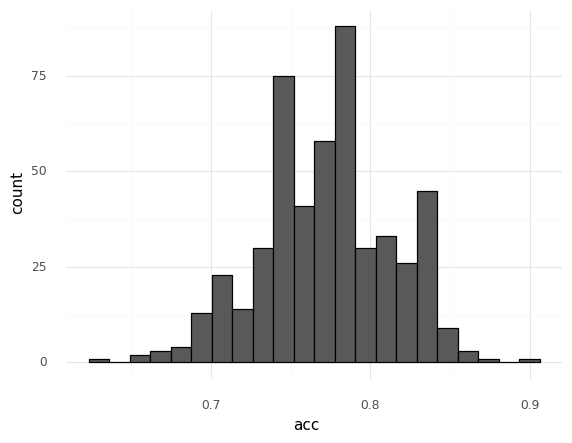

<ggplot: (8788125269733)>

In [26]:
# plot a histogram or density plot of the different accuracy values

(ggplot(acc_df, aes(x = "acc")) + geom_histogram(color = "black") + theme_minimal())

### Reflection

The accuracy is *relatively* stable, but it varies a lot. That means that the accuracy for my model is a good *estimate* of what the train set accuracy will be, but it can vary a lot. In this case, about 10% in either direction. That means I should have a little wiggle room in interpreting how well my model is doing.

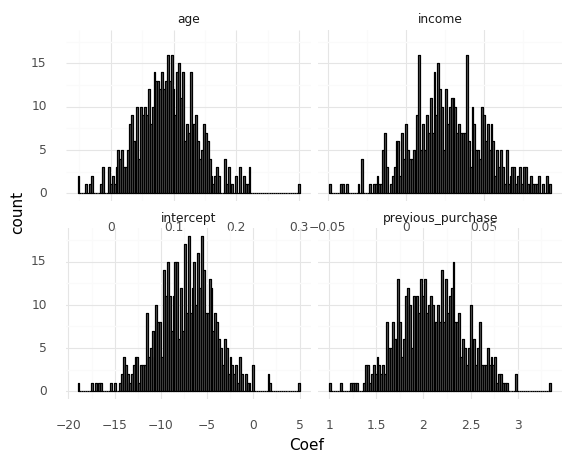

<ggplot: (8788125728154)>

In [29]:
# plot a histogram or density plot of the different coefficient values

((ggplot(coef_df, aes(x = "Coef")) + geom_histogram(color = "black") + theme_minimal() + facet_wrap("~Names", scales = "free_x")))